In [ ]:
from IPython.display import clear_output
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d sumanthvrao/daily-climate-time-series-data
!unzip daily-climate-time-series-data.zip
!rm daily-climate-time-series-data.zip
!pip install -q pmdarima
clear_output()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

from pmdarima.arima import auto_arima
from scipy import stats

import tensorflow as tf
from itertools import combinations

In [ ]:
np.random.seed(123)

def regression_results(y_true, y_pred):
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [ ]:
train = pd.read_csv('DailyDelhiClimateTrain.csv')
test = pd.read_csv('DailyDelhiClimateTest.csv')
train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [ ]:
train.info()  # no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [ ]:
train.describe()  # normal distribution

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


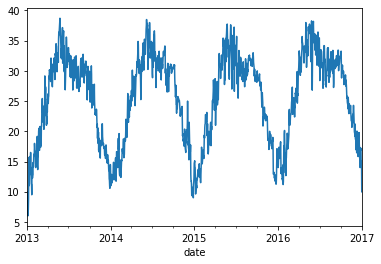

In [ ]:
ds = pd.Series(data=train['meantemp'].values, index=pd.to_datetime(train.date))
ds.plot()  # yearly seasonality?, no significant outliers or anomalies

In [ ]:
def correlation(df: pd.DataFrame, alpha=0.05, threshold=0.66, method='pearson'):
    data = df.copy()
    columns = data.select_dtypes(exclude=['category', np.object]).columns
    for pair in combinations(columns, r=2):
        col1, col2 = pair
        if method == 'pearson':
            r, pvalue = stats.pearsonr(data[col1], data[col2])
        elif method == 'kendall':
            r, pvalue = stats.kendalltau(data[col1], data[col2])
        elif method == 'spearman':
            r, pvalue = stats.spearmanr(data[col1], data[col2])                   
        else:
            raise ValueError(f'Method should be "spearman", "kendall" or "pearson", got: {method}')
        if r >= threshold:    
            if pvalue < alpha:
                print(f'Correlation ({method}) between {col1} and {col2} is statisticaly strong: {r:.4f}.')
            else:
                print(f'Correlation ({method}) between {col1} and {col2} is high but not statisticaly meaningful.')

In [ ]:
correlation(train.drop('date', axis=1), threshold=0.3, method='spearman')  # no actually strong correlations

Correlation (spearman) between meantemp and wind_speed is statisticaly strong: 0.3727.
Correlation (spearman) between humidity and meanpressure is statisticaly strong: 0.3097.


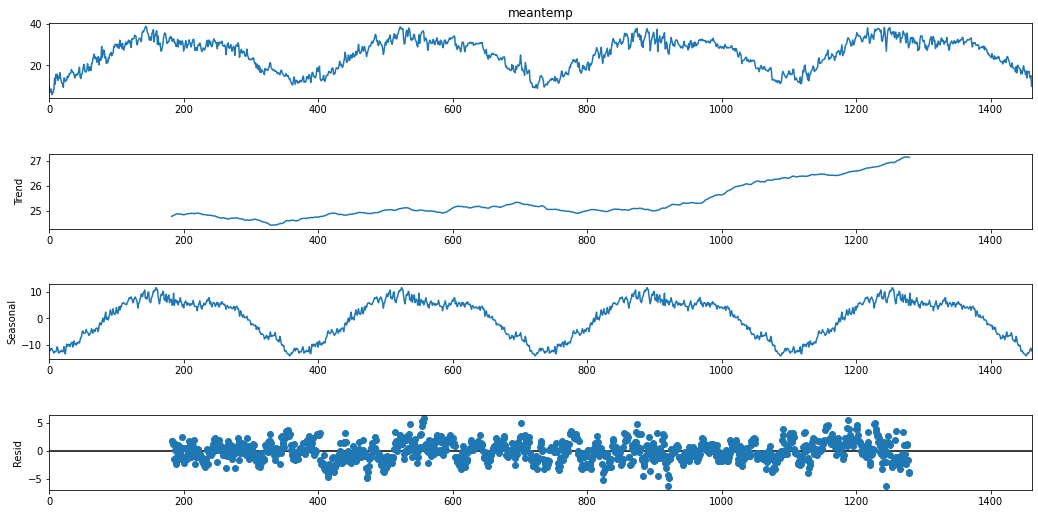

In [ ]:
decompose = seasonal_decompose(train['meantemp'], model='additive', period=365)
fig = decompose.plot()
fig.set_figheight(8)
fig.set_figwidth(16)
plt.show()

In [ ]:
dftest = adfuller(train['meantemp'].diff().dropna(), autolag='AIC', regression='ct')
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'], dftest))
# the data is stationary, d=1

{'adf': -16.466643282135145,
 'criticalvalues': {'1%': -3.9650227606650352,
  '10%': -3.1288338150660353,
  '5%': -3.4135200819990335},
 'icbest': 5422.485697443508,
 'nobs': 1451,
 'pvalue': 0.0,
 'usedlag': 9}

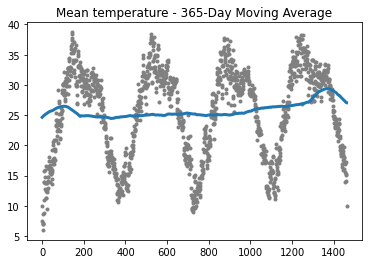

In [ ]:
moving_average = train['meantemp'].rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = train['meantemp'].plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Mean temperature - 365-Day Moving Average", legend=False,
);
# trend

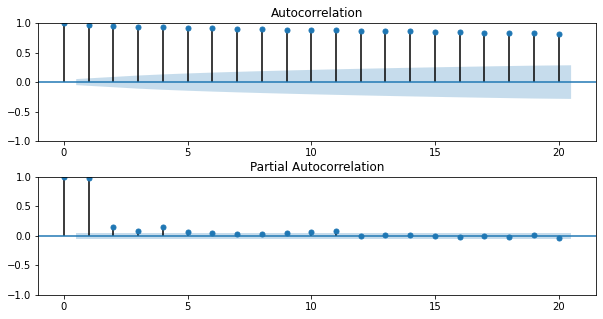

In [ ]:
# one diff
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
fig = plot_acf(train['meantemp'], lags=20, ax=ax[0])
fig = plot_pacf(train['meantemp'], lags=20, ax=ax[1])
plt.subplots_adjust(hspace=0.3)
plt.show()

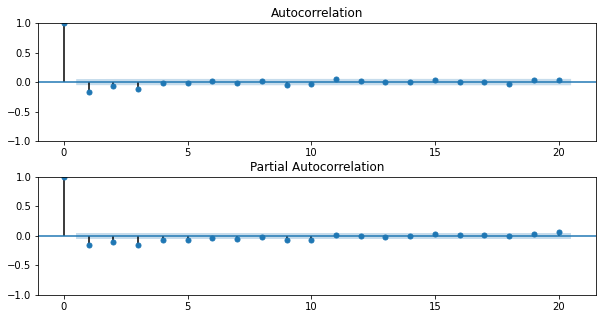

In [ ]:
# one diff
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
fig = plot_acf(train['meantemp'].diff().dropna(), lags=20, ax=ax[0])
fig = plot_pacf(train['meantemp'].diff().dropna(), lags=20, ax=ax[1])
plt.subplots_adjust(hspace=0.3)
plt.show()
# p = 1, q = 0, q = 1..5, use 2-4 lag-features

In [ ]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [ ]:
train['date'] = pd.to_datetime(train['date'])
train_ = train.set_index('date').to_period('D')

test['date'] = pd.to_datetime(test['date'])
test_ = test.set_index('date').to_period('D')

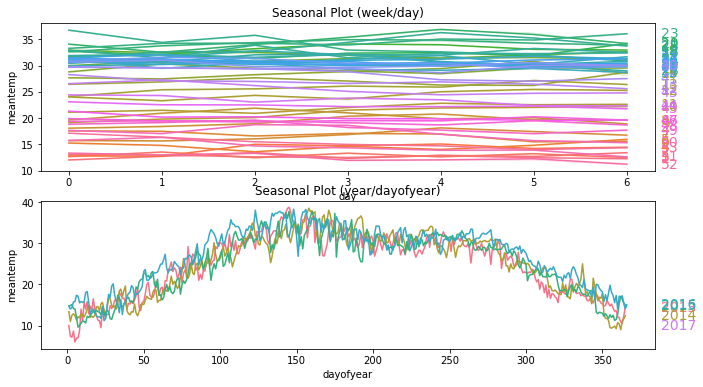

In [ ]:
X = train_.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="meantemp", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="meantemp", period="year", freq="dayofyear", ax=ax1);

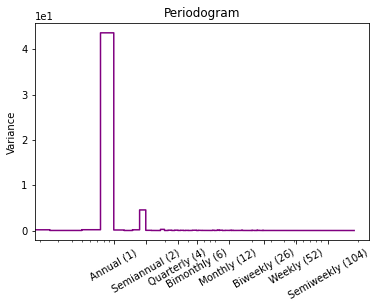

In [ ]:
plot_periodogram(train['meantemp'])  # ANNUAL seasonality

In [ ]:
fourier = CalendarFourier(freq="A", order=2)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=train_.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample() 

In [ ]:
X.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)"
date,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000
2013-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.017213,0.999852,0.034422,0.999407
2013-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.034422,0.999407,0.068802,0.997630
2013-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.051620,0.998667,0.103102,0.994671
2013-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.068802,0.997630,0.137279,0.990532


In [ ]:
train.corr()

,meantemp,humidity,wind_speed,meanpressure
meantemp,1.000000,-0.571951,0.306468,-0.038818
humidity,-0.571951,1.000000,-0.373972,0.001734
wind_speed,0.306468,-0.373972,1.000000,-0.020670
meanpressure,-0.038818,0.001734,-0.020670,1.000000


In [ ]:
roll_train_exp = train['meantemp'].ewm(span=10, adjust=False).mean()
weights = np.arange(1,11)
roll_train_w = train['meantemp'].rolling(10).apply(lambda x: np.dot(x, weights)/weights.sum(), raw=True)
roll_train_ = train['meantemp'].rolling(window=10).mean()

In [ ]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)
    
def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

In [ ]:
make_lags(ds, 4)

,y_lag_1,y_lag_2,y_lag_3,y_lag_4
date,,,,
2013-01-01,NaN,NaN,NaN,NaN
2013-01-02,10.000000,NaN,NaN,NaN
2013-01-03,7.400000,10.000000,NaN,NaN
2013-01-04,7.166667,7.400000,10.000000,NaN
2013-01-05,8.666667,7.166667,7.400000,10.000000
...,...,...,...,...
2016-12-28,16.850000,17.142857,14.000000,17.318182
2016-12-29,17.217391,16.850000,17.142857,14.000000
2016-12-30,15.238095,17.217391,16.850000,17.142857


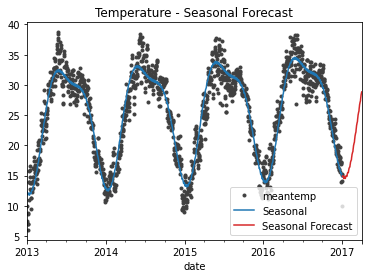

In [ ]:
y = train_["meantemp"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=train_.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Temperature - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

In [ ]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            return X
        return X[self.columns]

class Fourier(BaseEstimator, TransformerMixin):
    def __init__(self, season="A", order=2):
        self.fourier = CalendarFourier(freq=season, order=order)
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = X.copy()
        dp = DeterministicProcess(
            index=X_.index,
            constant=True,               # dummy feature for bias (y-intercept)
            order=1,                     # trend (order 1 means linear)
            seasonal=True,               # weekly seasonality (indicators)
            additional_terms=[self.fourier],  # annual seasonality (fourier)
            drop=True,                   # drop terms to avoid collinearity
        )
        X_ = dp.in_sample() 
        return X_

class RollingWindow(BaseEstimator, TransformerMixin):
    def __init__(self, window_size=5, method=None):
        self.method = method
        self.window_size = window_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        roll_exp = X['meantemp'].ewm(span=self.window_size, adjust=False).mean()
        weights = np.arange(1,self.window_size+1)
        roll_w = X['meantemp'].rolling(self.window_size).apply(lambda x: np.dot(x, weights)/weights.sum(), raw=True)
        roll_ = X['meantemp'].rolling(window=self.window_size).mean()
        return pd.concat([roll_exp, roll_w, roll_], axis=1)

class LagFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, n_lags=5):
        self.n_lags = n_lags

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return self.make_lags(X, self.n_lags)

    @staticmethod
    def make_lags(ts, lags):
        return pd.concat(
            {
                f'y_lag_{i}': ts.shift(i)
                for i in range(1, lags + 1)
            },
            axis=1)

In [ ]:
total = pd.concat([train_, test_], axis=0)
total.shape

(1576, 4)

In [ ]:
y = total['meantemp'].copy()

In [ ]:
base_columns = ['humidity', 'wind_speed', 'meanpressure']
target_column = ['meantemp',]

base_pipe = Pipeline(steps=[('selector1', ColumnSelector(base_columns)),
                            ('scaler', MinMaxScaler())])

fourier_pipe = Pipeline(steps=[('selector2', ColumnSelector(target_column)),
                               ('fourier', Fourier())])

rolling_pipe = Pipeline(steps=[('selector3', ColumnSelector(target_column)),
                               ('rolling', RollingWindow())])

lag_pipe = Pipeline(steps=[('selector4', ColumnSelector(target_column)),
                           ('lags', LagFeatures())])

union = FeatureUnion(transformer_list=[('base', base_pipe),
                                       ('fourier_pipe', fourier_pipe),
                                       ('rolling_pipe', rolling_pipe),
                                       ('lag_pipe', lag_pipe)])

In [ ]:
X = union.fit_transform(total)
X = pd.DataFrame(data=X, columns=[f'ft_{i+1}' for i in range(X.shape[1])], index=total.index)

In [ ]:
X.dropna(inplace=True)
cols_to_normalize = X.columns[-8:].tolist()
column_normilizer = ColumnTransformer(transformers=[('norm', MinMaxScaler(), cols_to_normalize)], 
                                      remainder='passthrough')
X = column_normilizer.fit_transform(X)

In [ ]:
X = pd.DataFrame(data=X, columns=[f'ft_{i+1}' for i in range(X.shape[1])], index=total.index[5:])

In [ ]:
X.head().transpose()

date,2013-01-06,2013-01-07,2013-01-08,2013-01-09,2013-01-10
ft_1,0.005088,0.000000,0.017036,0.084965,0.097251
ft_2,0.002650,0.000000,0.018162,0.087944,0.114036
ft_3,0.002608,0.000000,0.011023,0.045800,0.078403
ft_4,0.000000,0.030568,0.030568,0.087336,0.244541
ft_5,0.081514,0.000000,0.030568,0.030568,0.087336
ft_6,0.035662,0.081514,0.000000,0.030568,0.030568
ft_7,0.042795,0.035662,0.081514,0.000000,0.030568
ft_8,0.122271,0.042795,0.035662,0.081514,0.000000
ft_9,0.801320,0.752805,0.580858,0.436881,0.561056
ft_10,0.035054,0.149218,0.169182,0.296068,0.175272


In [ ]:
# X_test + 5 last rows from X_train

In [ ]:
y = make_multistep_target(y, steps=8).dropna()

In [ ]:
y, X = y.align(X, join='inner', axis=0)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False, random_state=123)

In [ ]:
correlation(X)

Correlation (pearson) between ft_1 and ft_2 is statisticaly strong: 0.9993.
Correlation (pearson) between ft_1 and ft_3 is statisticaly strong: 0.9981.
Correlation (pearson) between ft_1 and ft_4 is statisticaly strong: 0.9888.
Correlation (pearson) between ft_1 and ft_5 is statisticaly strong: 0.9845.
Correlation (pearson) between ft_1 and ft_6 is statisticaly strong: 0.9768.
Correlation (pearson) between ft_1 and ft_7 is statisticaly strong: 0.9687.
Correlation (pearson) between ft_1 and ft_8 is statisticaly strong: 0.9610.
Correlation (pearson) between ft_2 and ft_3 is statisticaly strong: 0.9980.
Correlation (pearson) between ft_2 and ft_4 is statisticaly strong: 0.9909.
Correlation (pearson) between ft_2 and ft_5 is statisticaly strong: 0.9866.
Correlation (pearson) between ft_2 and ft_6 is statisticaly strong: 0.9764.
Correlation (pearson) between ft_2 and ft_7 is statisticaly strong: 0.9642.
Correlation (pearson) between ft_2 and ft_8 is statisticaly strong: 0.9525.
Correlation 

In [ ]:
lr = LinearRegression(fit_intercept=False)

lr.fit(X_train, y_train)

y_fit = pd.DataFrame(lr.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(lr.predict(X_test), index=X_test.index, columns=y.columns)

In [ ]:
y_pred.head()

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8
date,,,,,,,,
2016-03-25,29.875000,28.990718,28.216158,28.172100,28.221137,28.228936,28.165196,28.052446
2016-03-26,24.666667,25.238974,25.945970,26.763905,26.920902,27.253485,27.414140,27.532108
2016-03-27,26.250000,26.607103,27.190649,27.206919,27.521313,27.593780,27.719550,27.591448
2016-03-28,25.933333,69.488885,214.655116,373.366840,425.691030,442.284819,477.524210,469.653117
2016-03-29,27.125000,27.143597,27.360654,27.384118,27.621836,27.510421,28.217326,28.624720


In [ ]:
regression_results(y_train, y_fit)
print('-'*30)
regression_results(y_test.iloc[:, 0], y_pred.iloc[:, 0])
print('-'*30)
regression_results(y_test.iloc[:, 1], y_pred.iloc[:, 1])
print('-'*30)
regression_results(y_test.iloc[:, 2], y_pred.iloc[:, 2])
# as we can see, the error increases while we propagate forward in future (when trying to forecast more steps)

explained_variance:  0.9352
r2:  0.9352
MAE:  1.3472
MSE:  3.4241
RMSE:  1.8504
------------------------------
explained_variance:  0.9963
r2:  0.9963
MAE:  0.0302
MSE:  0.1784
RMSE:  0.4224
------------------------------
explained_variance:  0.8329
r2:  0.8314
MAE:  1.4802
MSE:  7.9633
RMSE:  2.8219
------------------------------
explained_variance:  -1.1458
r2:  -1.1484
MAE:  2.4641
MSE:  101.5514
RMSE:  10.0773


In [ ]:
np.linalg.matrix_rank(X_train.values)

22

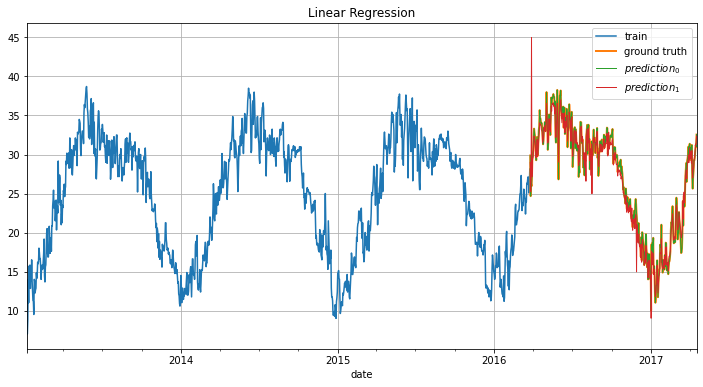

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Linear Regression')
y_train.iloc[:, 0].plot(label='train')
y_test.iloc[:, 0].plot(label='ground truth', lw=2)
y_pred.iloc[:, 0].plot(label=f'$prediction_0$', lw=1)
y_pred_clip = pd.Series(data=np.clip(y_pred.iloc[:, 1], -10, 45), name='Clipped', index=y_pred.index)
y_pred_clip.plot(label=f'$prediction_1$', lw=1)
plt.grid()
plt.legend()
plt.show()

In [ ]:
model_params = {
                'max_depth': 3,
                'learning_rate': 0.05,
                'reg_lambda': 3.5558022964925784,
                'gamma': 10.251324896139861,
                'subsample': 0.5,
                'colsample_bytree': 0.6,
                'tree_method': 'hist',
                'max_bin': 255,
                'n_estimators': 200, 
                'min_child_weight': 1.,
                'random_state': 42, 
}

In [ ]:
model = MultiOutputRegressor(XGBRegressor(
                                          objective='reg:squarederror', **model_params))
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

In [ ]:
regression_results(y_train, y_fit)
print('-'*30)
regression_results(y_test, y_pred)
# model overfits, but not dramaticaly. We can assume using boosting model for 8-step forecast is better.

explained_variance:  0.9599
r2:  0.9599
MAE:  1.1436
MSE:  2.1232
RMSE:  1.4571
------------------------------
explained_variance:  0.9111
r2:  0.9005
MAE:  1.7295
MSE:  4.7301
RMSE:  2.1749


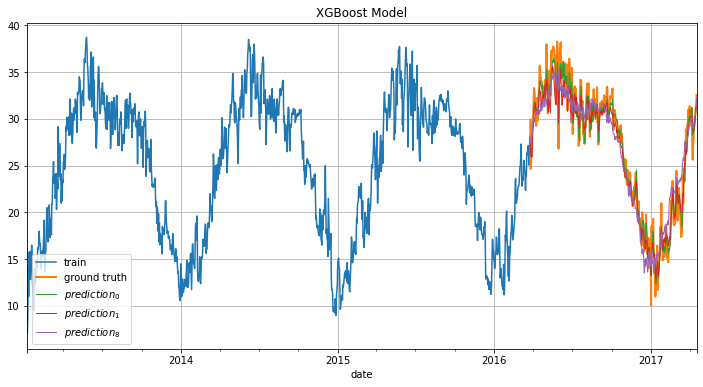

In [ ]:
plt.figure(figsize=(12,6))
plt.title('XGBoost Model')
y_train.iloc[:, 0].plot(label='train')
y_test.iloc[:, 0].plot(label='ground truth', lw=2)
y_pred.iloc[:, 0].plot(label=f'$prediction_0$', lw=1)
y_pred_clip = pd.Series(data=np.clip(y_pred.iloc[:, 1], -10, 45), name='Clipped', index=y_pred.index)
y_pred_clip.plot(label=f'$prediction_1$', lw=1)
y_pred.iloc[:, 7].plot(label=f'$prediction_8$', lw=1)
plt.grid()
plt.legend()
plt.show()

In [ ]:
scaler = RobustScaler()
ys_train = pd.Series(data=train_['meantemp'], name='meantemp', index=train_.index)
ys_test = pd.Series(data=test_['meantemp'], name='meantemp', index=test_.index)
Xs_train = scaler.fit_transform(train_.drop('meantemp', axis=1))
Xs_test = scaler.transform(test_.drop('meantemp', axis=1))
Xs_train = pd.DataFrame(data=Xs_train, columns=train_.drop('meantemp', axis=1).columns, index=train_.index)
Xs_test = pd.DataFrame(data=Xs_test, columns=test_.drop('meantemp', axis=1).columns, index=test_.index)

In [ ]:
# SARIMAX raw features
step_wise = auto_arima(ys_train, exogenous=Xs_train, 
                       start_p=0, start_q=0,  
                       max_p=7, max_q=7,  d=1, max_d=2, 
                       trend='ct', trace=True, 
                       error_action='ignore', suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4809.863, Time=0.93 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4811.448, Time=1.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4811.776, Time=2.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4809.863, Time=0.67 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4815.103, Time=1.64 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 6.769 seconds


In [ ]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1462
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -2585.584
Date:                Sun, 13 Mar 2022   AIC                           5189.168
Time:                        06:54:06   BIC                           5236.756
Sample:                    01-01-2013   HQIC                          5206.919
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        2.4289      0.270      9.009      0.000       1.900       2.957
drift            0.0001      0.000      0.798      0.425      -0.000       0.000
humidity        -3.8555      0.074    -52.284      0.000      -4.000      -3.711
wind_speed      -0.1345      0.035     -3.833      0.000      -0.203      -0.066
meanpressure    -0.0012      0.002     -0.520      0.603      -0.006       0.003
ar.L1            0.9013      0.011     81.480      0.000       0.880       0.923
ma.L1            0.4688      0.017     27.373      0.000       0.435       0.502
ma.L2            0.3514      0.017     20.230      0.000       0.317       0.385
sigma2           1.9364      0.054     35.919      0.000       1.831       2.042
===================================================================================
Ljung-Box (L1) (Q):                  61.95   Jarque-Bera (JB):               424.10
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -0.53
Prob(H) (two-sided):                  0.03   Kurtosis:                         5.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
sarima = SARIMAX(ys_train, exog=Xs_train, order=(2,1,1), seasonal_order=(2, 1, 1, 12), enforce_invertibility=False,
               enforce_stationarity=False, trend='ct')

In [ ]:
results = sarima.fit()

In [ ]:
predictions = results.predict(start=Xs_train.shape[0], end=Xs_train.shape[0] + Xs_test.shape[0] - 1, exog=Xs_test)

In [ ]:
regression_results(ys_test, predictions)

explained_variance:  0.8344
r2:  0.6312
MAE:  3.2197
MSE:  14.7877
RMSE:  3.8455


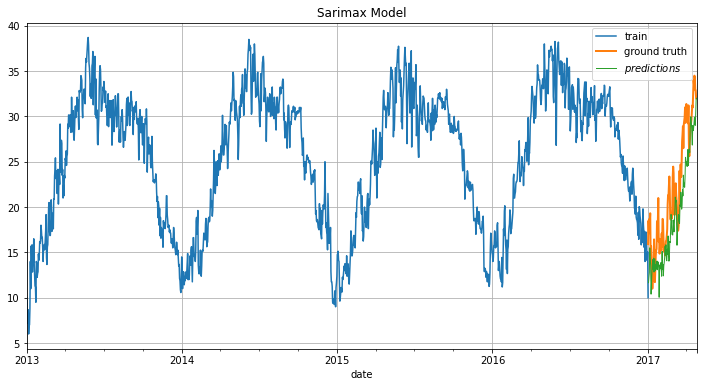

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Sarimax Model')
ys_train.plot(label='train')
ys_test.plot(label='ground truth', lw=2)
predictions.plot(label=f'$predictions$', lw=1)
plt.grid()
plt.legend()
plt.show()

In [ ]:
# LSTM-model

In [ ]:
# another function to create multistep data
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X, y = [], []
    start += window
    if end is None:
        end = len(dataset) - horizon
    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])
        indicesy = range(i+1, i+horizon+1)
        y.append(target[indicesy])
    return np.array(X), np.array(y)

In [ ]:
X, y = total.drop('meantemp', axis=1), total[['meantemp']]
scaler = RobustScaler()
y_scaler = RobustScaler()
dataX = scaler.fit_transform(X)
dataY = y_scaler.fit_transform(y)

In [ ]:
hist_window = 24
horizon = 8
train_split = 1174
batch_size = 4
buffer_size = 50

In [ ]:
X_train, y_train = custom_ts_multi_data_prep(dataX, dataY, 0, train_split, hist_window, horizon)
X_test, y_test = custom_ts_multi_data_prep(dataX, dataY, train_split, None, hist_window, horizon)

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).cache().shuffle(buffer_size).batch(batch_size).repeat()
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).repeat()

In [ ]:
# bidirectional LSTM
seq = [
       tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, return_sequences=True), 
                                     input_shape=X_train.shape[-2:]),
       tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
       tf.keras.layers.Dense(20, activation='relu'),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.Dense(horizon)
]
# autoencoder
seq = [
       tf.keras.layers.LSTM(40, input_shape=X_train.shape[-2:], return_sequences=True),
       tf.keras.layers.LSTM(20, return_sequences=True),
       tf.keras.layers.LSTM(15),
       tf.keras.layers.RepeatVector(y_train.shape[1]),
       tf.keras.layers.LSTM(40, return_sequences=True),
       tf.keras.layers.LSTM(25, return_sequences=True),
       tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
]
model = tf.keras.models.Sequential(seq)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_79 (LSTM)              (None, 24, 40)            7040      
                                                                 
 lstm_80 (LSTM)              (None, 24, 20)            4880      
                                                                 
 lstm_81 (LSTM)              (None, 15)                2160      
                                                                 
 repeat_vector_11 (RepeatVec  (None, 8, 15)            0         
 tor)                                                            
                                                                 
 lstm_82 (LSTM)              (None, 8, 40)             8960      
                                                                 
 lstm_83 (LSTM)              (None, 8, 25)             6600      
                                                     

In [ ]:
eval_interval = 50
epochs = 150
history = model.fit(train_data, epochs=epochs, steps_per_epoch=eval_interval, validation_data=test_data,
                    validation_steps=10, verbose=1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, 
                                                                verbose=1, mode='min'),
                               tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=6, factor=0.1, 
                                                                    min_lr=1e-6)])

Epoch 1/150
50/50 [==============================] - 16s 80ms/step - loss: 0.1344 - val_loss: 0.1386 - lr: 0.0010
Epoch 2/150
50/50 [==============================] - 2s 36ms/step - loss: 0.0997 - val_loss: 0.2596 - lr: 0.0010
Epoch 3/150
50/50 [==============================] - 2s 36ms/step - loss: 0.0681 - val_loss: 0.1629 - lr: 0.0010
Epoch 4/150
50/50 [==============================] - 2s 36ms/step - loss: 0.0915 - val_loss: 0.1265 - lr: 0.0010
Epoch 5/150
50/50 [==============================] - 2s 37ms/step - loss: 0.0559 - val_loss: 0.1453 - lr: 0.0010
Epoch 6/150
50/50 [==============================] - 2s 36ms/step - loss: 0.0721 - val_loss: 0.1499 - lr: 0.0010
Epoch 7/150
50/50 [==============================] - 2s 36ms/step - loss: 0.0440 - val_loss: 0.0883 - lr: 0.0010
Epoch 8/150
50/50 [==============================] - 2s 36ms/step - loss: 0.0573 - val_loss: 0.0943 - lr: 0.0010
Epoch 9/150
50/50 [==============================] - 2s 36ms/step - loss: 0.0431 - val_loss: 0.

In [ ]:
data_for_prediction = X_test[:hist_window*15, :]
y_pred = model.predict(data_for_prediction)

In [ ]:
y_pred_unscaled = y_scaler.inverse_transform(y_pred.squeeze())
regression_results(y_test[:hist_window*15].squeeze(), y_pred.squeeze())

explained_variance:  0.7526
r2:  0.7507
MAE:  0.2259
MSE:  0.0767
RMSE:  0.2769


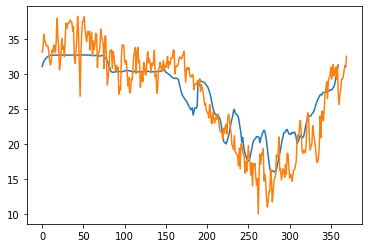

In [ ]:
plt.plot(y_scaler.inverse_transform(y_pred.squeeze()[:,0].reshape(-1,1)))
plt.plot(y_scaler.inverse_transform(y_test.squeeze()[:,0].reshape(-1,1)))